#### <a>Objective: To predict the House Prices. 

#### <a>Business Context:

The buyers are just not concerned about the size(square feet) of the house and there are various other factors that play a key role to decide the price of a house/property.
    
#### <a>Data Description:

date: Date house was sold<br>
price: Price is prediction target<br>
bedrooms: Number of Bedrooms per House<br>
bathrooms: Number of bathrooms per House<br>
sqft_living: Square Feet of the home<br>
sqft_lot: Square Feet of the lot<br>
floors: Total floors (levels) in house<br>
waterfront: House which has a view to a waterfront<br>
view: Number of Views from the house<br>
condition: How good the condition is (Overall)<br>
sqft_above: Square Feet of house apart from basement<br>
sqft_basement: Square Feet of the basement<br>
yr_built: Built Year<br>
yr_renovated: Year when house was renovated<br>
street: Street Address<br>
city: City Name<br>
statezip: Zip<br>
country: Country Name<br>

#### <a>Importing Modules

In [1]:
import numpy as np
import pandas as pd

import pandas_profiling

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.feature_selection import f_regression, RFE, VarianceThreshold
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices

import scipy.stats as stats
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV

import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from keras.models import Sequential
from keras.layers import Dense, Dropout

from sklearn import metrics

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

#### <a>Creating UDFs

In [2]:
# Create Statistical Summary for continuous variables
def continuous_var_summary(x):
    return pd.Series([x.count(), len(x.value_counts()), x.isnull().sum(), x.sum(), x.mean(), x.median(),  
                      x.std(), x.var(), x.min(), x.quantile(0.01), x.quantile(0.05), x.quantile(0.50),
                      x.quantile(0.95), x.quantile(0.99),x.max()], 
                      index = ['Count', 'Unique', 'NMISS', 'SUM', 'MEAN','MEDIAN', 'STD', 'VAR', 'MIN',
                               'P1', 'P5', 'P50', 'P95', 'P99' ,'MAX'])

In [3]:
# Create Statistical Summary for categorical variables
def categorical_var_summary(a):
    Mode = a.value_counts().sort_values(ascending = False)[0:1].reset_index()
    return pd.Series([a.count(), a.isnull().sum(), len(a.value_counts()), Mode.iloc[0, 0], Mode.iloc[0, 1], 
                      round(((Mode.iloc[0, 1] * 100)/a.count()), 2)], 
                      index = ['COUNT', 'MISS', 'UNIQUE', 'MODE', 'FREQ', 'PERCENT'])

In [4]:
#Outlier treatment function
def outlier_capping(x):
    x = x.clip(lower = x.quantile(0.01),upper = x.quantile(0.99))
    return x

In [5]:
# Missing value imputation for categorical and continuous variables
def missing_imputation(x, stats = 'mean'):
    if (x.dtypes == 'float64') | (x.dtypes == 'int64'):
        x = x.fillna(x.mean()) if stats == 'mean' else x.fillna(x.median())
    else:
        x = x.fillna(x.mode().iloc[0])
    return x

In [6]:
# An utility function to create dummy variable
def create_dummies(df, colname):
    col_dummies = pd.get_dummies(df[colname], prefix = colname, drop_first = True)
    df = pd.concat([df, col_dummies], axis = 1)
    df.drop(colname, axis = 1, inplace = True )
    return df

#### <a>Loading Dataset

In [7]:
data_house = pd.read_csv('Data Set/data.csv')

#### <a>Understanding data

In [8]:
#Data View
data_house.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
0,2014-05-02 00:00:00,313000.0,3.0,1.50,1340,7912,1.5,0,0,3,1340,0,1955,2005,18810 Densmore Ave N,Shoreline,WA 98133,USA
1,2014-05-02 00:00:00,2384000.0,5.0,2.50,3650,9050,2.0,0,4,5,3370,280,1921,0,709 W Blaine St,Seattle,WA 98119,USA
2,2014-05-02 00:00:00,342000.0,3.0,2.00,1930,11947,1.0,0,0,4,1930,0,1966,0,26206-26214 143rd Ave SE,Kent,WA 98042,USA
3,2014-05-02 00:00:00,420000.0,3.0,2.25,2000,8030,1.0,0,0,4,1000,1000,1963,0,857 170th Pl NE,Bellevue,WA 98008,USA
4,2014-05-02 00:00:00,550000.0,4.0,2.50,1940,10500,1.0,0,0,4,1140,800,1976,1992,9105 170th Ave NE,Redmond,WA 98052,USA


In [9]:
#Basic Data Information
data_house.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4600 entries, 0 to 4599
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           4600 non-null   object 
 1   price          4600 non-null   float64
 2   bedrooms       4600 non-null   float64
 3   bathrooms      4600 non-null   float64
 4   sqft_living    4600 non-null   int64  
 5   sqft_lot       4600 non-null   int64  
 6   floors         4600 non-null   float64
 7   waterfront     4600 non-null   int64  
 8   view           4600 non-null   int64  
 9   condition      4600 non-null   int64  
 10  sqft_above     4600 non-null   int64  
 11  sqft_basement  4600 non-null   int64  
 12  yr_built       4600 non-null   int64  
 13  yr_renovated   4600 non-null   int64  
 14  street         4600 non-null   object 
 15  city           4600 non-null   object 
 16  statezip       4600 non-null   object 
 17  country        4600 non-null   object 
dtypes: float

In [10]:
#Changing Categorical variables to object
data_house[['waterfront','condition']] = data_house[['waterfront','condition']].astype('object')

In [11]:
#Dropping date variable as it has no significance for our prediction model
data_house.drop('date', axis = 1, inplace = True)

#### <a>Variables Statistical Summary

In [12]:
#Continuous Variable Summary
data_house.select_dtypes(['int64','float64']).apply(continuous_var_summary)

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,view,sqft_above,sqft_basement,yr_built,yr_renovated
Count,4.600000e+03,4600.000000,4600.000000,4.600000e+03,4.600000e+03,4600.000000,4600.000000,4.600000e+03,4.600000e+03,4.600000e+03,4.600000e+03
Unique,1.741000e+03,10.000000,26.000000,5.660000e+02,3.113000e+03,6.000000,5.000000,5.110000e+02,2.070000e+02,1.150000e+02,6.000000e+01
NMISS,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
SUM,2.539030e+09,15644.000000,9939.750000,9.840996e+06,6.832157e+07,6955.500000,1107.000000,8.405421e+06,1.435575e+06,9.065617e+06,3.719598e+06
MEAN,5.519630e+05,3.400870,2.160815,2.139347e+03,1.485252e+04,1.512065,0.240652,1.827265e+03,3.120815e+02,1.970786e+03,8.086083e+02
MEDIAN,4.609435e+05,3.000000,2.250000,1.980000e+03,7.683000e+03,1.500000,0.000000,1.590000e+03,0.000000e+00,1.976000e+03,0.000000e+00
STD,5.638347e+05,0.908848,0.783781,9.632069e+02,3.588444e+04,0.538288,0.778405,8.621690e+02,4.641372e+02,2.973185e+01,9.794145e+02
VAR,3.179096e+11,0.826005,0.614313,9.277676e+05,1.287693e+09,0.289754,0.605914,7.433353e+05,2.154234e+05,8.839828e+02,9.592528e+05
MIN,0.000000e+00,0.000000,0.000000,3.700000e+02,6.380000e+02,1.000000,0.000000,3.700000e+02,0.000000e+00,1.900000e+03,0.000000e+00
P1,0.000000e+00,2.000000,1.000000,7.200000e+02,1.026950e+03,1.000000,0.000000,7.099000e+02,0.000000e+00,1.903000e+03,0.000000e+00


In [13]:
#Categorical Variable Summary
data_house.select_dtypes('object').apply(categorical_var_summary)

,waterfront,condition,street,city,statezip,country
COUNT,4600.00,4600.0,4600,4600,4600,4600
MISS,0.00,0.0,0,0,0,0
UNIQUE,2.00,5.0,4525,44,77,1
MODE,0.00,3.0,2520 Mulberry Walk NE,Seattle,WA 98103,USA
FREQ,4567.00,2875.0,4,1573,148,4600
PERCENT,99.28,62.5,0.09,34.2,3.22,100.0


Based on Statistical summary we can drop 'street','waterfront' and 'country'. 'street' has high number of unique values which will not be a good predictor for our model and 'country' has only one value & 'waterfront' has only 2 thus will not have any effect on our model.

#### <a>Data preparation

In [14]:
#Dropping street and country
data_house.drop(labels = ['street','country','waterfront'], axis = 1, inplace = True)

In [15]:
#Checking for missing values
data_house.isna().sum()

price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
view             0
condition        0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
city             0
statezip         0
dtype: int64

In [16]:
#Getting continuous and categorical variable list
cont_var = data_house.select_dtypes(['int64','float64']).columns
cat_var = data_house.select_dtypes('object').columns

In [17]:
#Handling Outliers
data_house[cont_var] = data_house[cont_var].apply(outlier_capping)

#### <a>EDA

1.9307248478709846


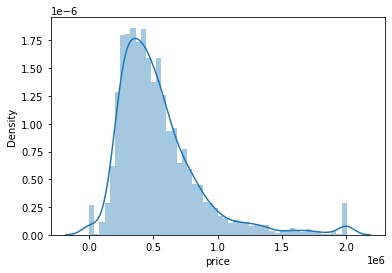

In [18]:
#Checking the distribution of target variable
sns.distplot(data_house.price,
              kde = True)
print(data_house.price.skew())

In [19]:
#Handling Disturbance in target variable and taking log to make distribution normal
data_house = data_house[(data_house['price']>0)&(data_house['price']<=2005000.0)]
data_house['log_price'] = np.log(data_house.price)

-0.045601540141737514


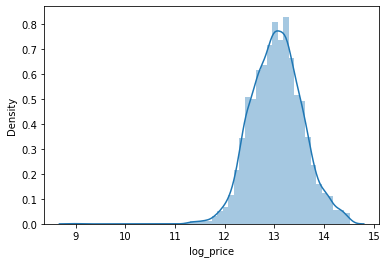

In [20]:
#Checking the distribution of new target variable - log_price
sns.distplot(data_house.log_price)
print(data_house.log_price.skew())

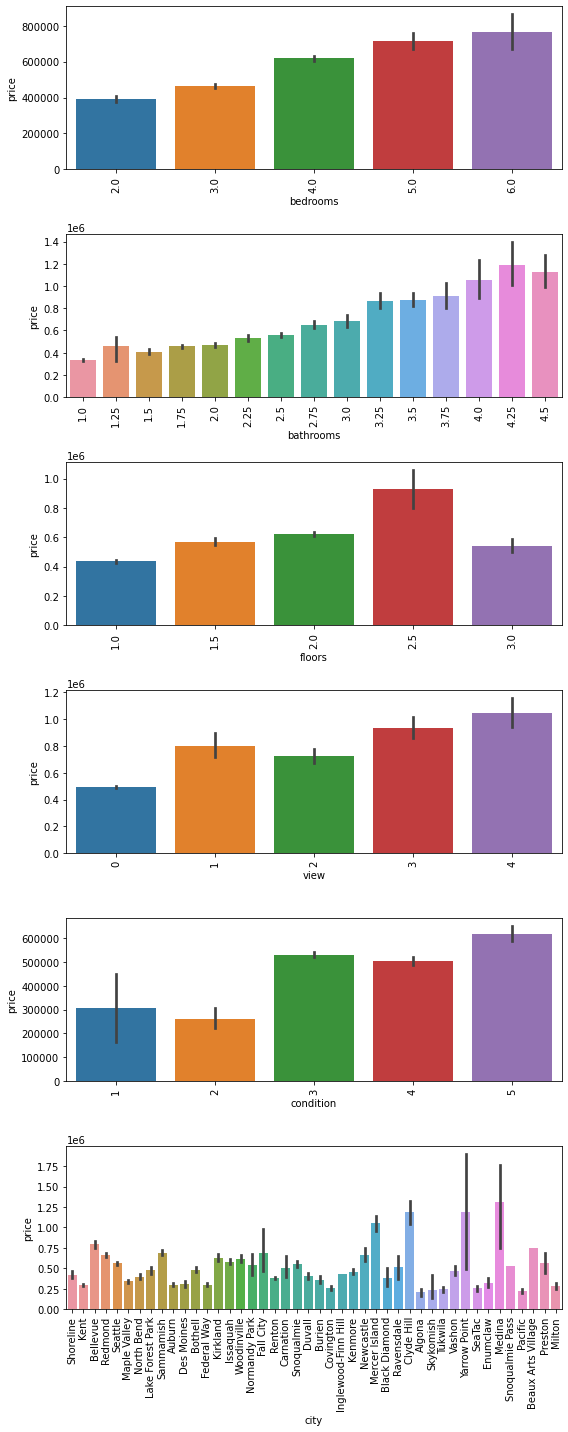

In [21]:
#Price across different variables
plt_cols = ['bedrooms', 'bathrooms', 'floors', 'view', 'condition', 'city']

plt.figure(figsize = (8,20))
for i, col in enumerate(plt_cols):
    plt.subplot(6, 1, i+1)
    plt.subplots_adjust(hspace = 1, wspace = .5)
    sns.barplot(x = data_house[col], y = data_house.price)
    plt.xticks(rotation = 90)
    plt.tight_layout()

Observations :
- Prices increases linearly with the number of bedrooms
- Prices also increases with number of bathrooms
- Price of house with 2.5 floors is high and it decreases for house with 3 floors
- House with 4 views have high price
- House with condition 3,4 or 5 have high price
- Prices of houses in Medina, Clyde Hill and Yarrow Point are the highest

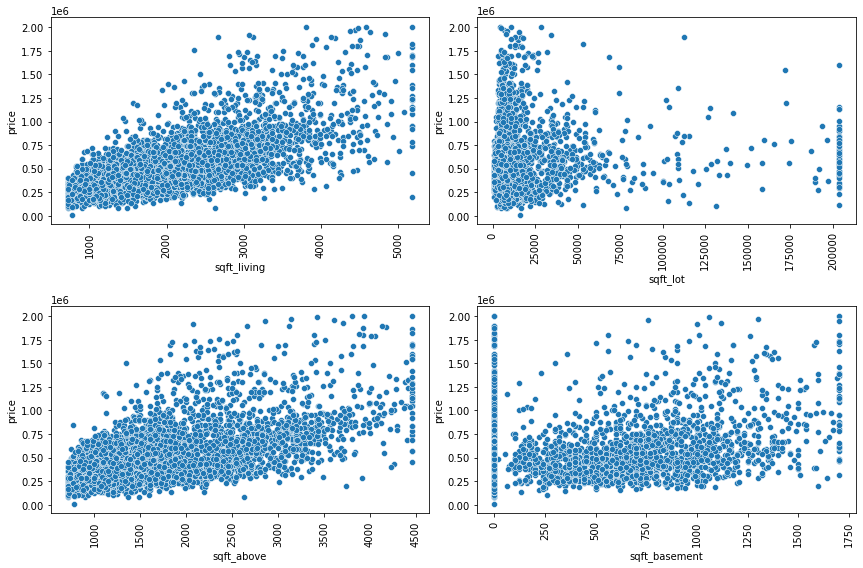

In [22]:
#Price across different area measures
plt_cols = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement']

plt.figure(figsize = (12,8))
for i, col in enumerate(plt_cols):
    plt.subplot(2, 2, i+1)
    plt.subplots_adjust(hspace = 1, wspace = .5)
    sns.scatterplot(x = data_house[col], y = data_house.price)
    plt.xticks(rotation = 90)
    plt.tight_layout()

Price is correlated with sqft_living and sqft_above

#### <a>Correlation Matrix

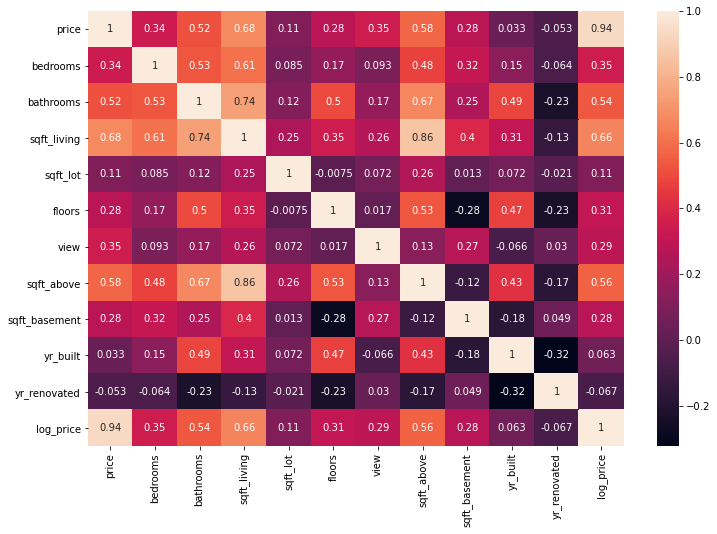

In [23]:
plt.figure(figsize = (12,8))
sns.heatmap(data_house.corr(), annot = True)
plt.show()

#### <a>Preprocessing data

In [24]:
#Creating dummy variables for categorical variables
data_house = create_dummies(data_house, cat_var)
data_house.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,view,sqft_above,sqft_basement,yr_built,...,statezip_WA 98155,statezip_WA 98166,statezip_WA 98168,statezip_WA 98177,statezip_WA 98178,statezip_WA 98188,statezip_WA 98198,statezip_WA 98199,statezip_WA 98288,statezip_WA 98354
0,313000.0,3.0,1.50,1340.0,7912.0,1.5,0,1340.0,0.0,1955,...,0,0,0,0,0,0,0,0,0,0
2,342000.0,3.0,2.00,1930.0,11947.0,1.0,0,1930.0,0.0,1966,...,0,0,0,0,0,0,0,0,0,0
3,420000.0,3.0,2.25,2000.0,8030.0,1.0,0,1000.0,1000.0,1963,...,0,0,0,0,0,0,0,0,0,0
4,550000.0,4.0,2.50,1940.0,10500.0,1.0,0,1140.0,800.0,1976,...,0,0,0,0,0,0,0,0,0,0
5,490000.0,2.0,1.00,880.0,6380.0,1.0,0,880.0,0.0,1938,...,0,0,0,0,0,0,0,0,0,0


#### <a>Feature Selection

In [25]:
#Removing space in column names
data_house.columns = data_house.columns.str.replace(' ', '')

In [26]:
#Using F-Regression
#Getting features and target
feat_cols = data_house.columns.difference(['price','log_price'])
target = data_house.log_price

#Performing f-test for each x variable with y
f_values, p_values = f_regression(data_house[feat_cols], target)

#Storing data as a DataFrame
fr_df = pd.DataFrame({'Features':feat_cols, 'F_values':f_values, 'p_values':p_values.round(3)})

#Getting significant variables at 90% : p = 0.1
f_cols = fr_df.loc[fr_df.p_values<=0.1, 'Features'].reset_index(drop = True)
f_cols

0             bathrooms
1              bedrooms
2           city_Auburn
3         city_Bellevue
4           city_Burien
             ...       
100    statezip_WA98199
101    statezip_WA98288
102                view
103            yr_built
104        yr_renovated
Name: Features, Length: 105, dtype: object

In [27]:
#Using Recursive Feature Elimination (RFE)
#Using RandomForestRegressor as an estimator
rf_est = RandomForestRegressor(random_state = 456)

#Using RFE to get importance of each variable
rfe = RFE(estimator =rf_est, n_features_to_select = 20)
rfe.fit(data_house[f_cols], target)

print(rfe.support_)
print(rfe.ranking_)

[ True  True  True  True False False False False False False  True  True
  True  True False False False False False False  True False  True False
  True False False False False False False False False False False  True
  True  True  True False False  True False False False False False False
 False False False False False False False False False  True False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False  True  True  True]
[ 1  1  1  1 47 64 28 49 33 57  1  1  1  1  9 48  4 41 40 72  1  5  1 34
  1 18 86 60  6 19 20 29 11 15  7  1  1  1  1 76 81  1 75 68 84 56 58 30
 35 71 66 67 77 85 12 23 26  1 16 61 80 45 82 74 55 70 38 37 44 73 69 78
 32 63 46 36  3 62 14 51 10 42 59 43 17 31 53 24 22 25 27 13 79 39 50  8
 54  2 65 21 52 83  1  1  1]


In [28]:
#Getting important features
rfe_cols = f_cols[rfe.support_].reset_index(drop = True)
rfe_cols

0            bathrooms
1             bedrooms
2          city_Auburn
3        city_Bellevue
4      city_FederalWay
5        city_Issaquah
6            city_Kent
7        city_Kirkland
8         city_Redmond
9       city_Sammamish
10        city_Seattle
11          sqft_above
12       sqft_basement
13         sqft_living
14            sqft_lot
15    statezip_WA98004
16    statezip_WA98040
17                view
18            yr_built
19        yr_renovated
Name: Features, dtype: object

In [29]:
#Getting Model Formula
'log_price ~ '+' + '.join(rfe_cols)

'log_price ~ bathrooms + bedrooms + city_Auburn + city_Bellevue + city_FederalWay + city_Issaquah + city_Kent + city_Kirkland + city_Redmond + city_Sammamish + city_Seattle + sqft_above + sqft_basement + sqft_living + sqft_lot + statezip_WA98004 + statezip_WA98040 + view + yr_built + yr_renovated'

In [30]:
model_fm = '''log_price ~ bathrooms + bedrooms + city_Auburn + city_Bellevue + city_FederalWay
+ city_Issaquah + city_Kent + city_Kirkland + city_Redmond + city_Sammamish + city_Seattle +
sqft_basement + sqft_living + sqft_lot + statezip_WA98004 + statezip_WA98040
+ view + yr_built + yr_renovated'''

In [31]:
#Using Variance Inflation Factor (VIF)
#Separating the X and Y variables
Y, X = dmatrices(model_fm, data_house, return_type = 'dataframe')

#Calculating VIF for each X and saving in DataFrame
vif = pd.DataFrame()
vif['Features'] = X.columns
vif['VIF Factor'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

#Getting features
vif_cols = list(set(vif.Features).difference(['Intercept']))

#VIF output
vif.round(1)

,Features,VIF Factor
0,Intercept,8333.2
1,bathrooms,3.0
2,bedrooms,1.7
3,city_Auburn,1.1
4,city_Bellevue,1.3
5,city_FederalWay,1.1
6,city_Issaquah,1.1
7,city_Kent,1.1
8,city_Kirkland,1.1
9,city_Redmond,1.1


Dropped 'sqft_above' feature having VIF Factor > 4. VIF Factor > 4 means high multicollinearity.

#### <a>Train and Test Data

In [32]:
#For Statistical modelling
train, test = train_test_split(data_house, test_size = 0.3, random_state = 123)

In [33]:
#Getting final model equation
'log_price ~ '+' + '.join(vif_cols)

'log_price ~ city_Issaquah + statezip_WA98040 + bedrooms + sqft_basement + statezip_WA98004 + city_FederalWay + city_Kent + yr_renovated + city_Sammamish + view + sqft_living + city_Redmond + city_Auburn + yr_built + city_Bellevue + bathrooms + city_Kirkland + city_Seattle + sqft_lot'

In [34]:
mo_fm = '''log_price ~ sqft_living + yr_renovated + sqft_lot + statezip_WA98040 + city_Auburn +
city_Seattle + yr_built + city_FederalWay + city_Sammamish + city_Kirkland + city_Kent +
bedrooms + city_Issaquah + statezip_WA98004 + bathrooms + sqft_basement + view + city_Redmond
+ city_Bellevue'''

#### <a>Linear Regression Model

In [35]:
#building model
lm0 = smf.ols(formula = mo_fm, data = train).fit()

In [36]:
#Model Summary
print(lm0.summary())

                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.709
Model:                            OLS   Adj. R-squared:                  0.707
Method:                 Least Squares   F-statistic:                     401.6
Date:                Thu, 16 Sep 2021   Prob (F-statistic):               0.00
Time:                        17:49:20   Log-Likelihood:                -411.73
No. Observations:                3153   AIC:                             863.5
Df Residuals:                    3133   BIC:                             984.6
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           16.1670      0.444  

Removing insignificant variables based on p-value > 0.05 from model summary - 'yr_renovated'

In [37]:
final_mo_fm = '''log_price ~ sqft_living + sqft_lot + statezip_WA98040 + city_Auburn +
city_Seattle + yr_built + city_FederalWay + city_Sammamish + city_Kirkland + city_Kent +
bedrooms + city_Issaquah + statezip_WA98004 + bathrooms + sqft_basement + view + city_Redmond
+ city_Bellevue'''

In [38]:
#building model with final model formula
lm1 = smf.ols(formula = final_mo_fm, data = train).fit()

In [39]:
print(lm1.summary())

                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.709
Model:                            OLS   Adj. R-squared:                  0.707
Method:                 Least Squares   F-statistic:                     423.5
Date:                Thu, 16 Sep 2021   Prob (F-statistic):               0.00
Time:                        17:49:20   Log-Likelihood:                -413.23
No. Observations:                3153   AIC:                             864.5
Df Residuals:                    3134   BIC:                             979.5
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           16.0048      0.435  

In [40]:
#Predicting total spent on train and test dataset
train.loc[:,'pred_price'] = np.exp(lm1.predict(train))
test.loc[:, 'pred_price'] = np.exp(lm1.predict(test))

#Getting Mean Absolute Percentage Error - MAPE
MAPE_train = np.mean(np.abs(train['price'] - train['pred_price'])/train['price'])
MAPE_test = np.mean(np.abs(test['price'] - test['pred_price'])/test['price'])

print('Training MAPE: ',MAPE_train,' | ','Testing MAPE:' ,MAPE_test)

Training MAPE:  0.2176723288482579  |  Testing MAPE: 0.24636976828129548


In [41]:
#Getting Mean Squared Error Metric - MSE
MSE_train = metrics.mean_squared_error(train.price, train.pred_price)
MSE_test = metrics.mean_squared_error(test.price, test.pred_price)

#Getting Root Mean Squared Error - RMSE
RMSE_train = np.sqrt(MSE_train)
lr_RMSE_test = np.sqrt(MSE_test)

print('Training MSE: ',MSE_train,' | ','Testing MSE:' ,MSE_test)
print('Training RMSE: ',RMSE_train,' | ','Testing RMSE:', lr_RMSE_test)

Training MSE:  28465203282.206886  |  Testing MSE: 29079847566.94841
Training RMSE:  168716.33970130718  |  Testing RMSE: 170528.14303495013


In [42]:
#Getting Mean Absolute Error Metric - MAE
MAE_train = metrics.mean_absolute_error(train.price, train.pred_price)
lr_MAE_test = metrics.mean_absolute_error(test.price, test.pred_price)

print('Training MAE: ',MAE_train,' | ','Testing MAE:' ,lr_MAE_test)

Training MAE:  107052.097037842  |  Testing MAE: 107448.05497228807


In [43]:
#Correlation between actual and predicted values
Corr_train = stats.stats.pearsonr(train.price, train.pred_price)
Corr_test = stats.stats.pearsonr(test.price, test.pred_price)

print('Correlation - Train Data: ', Corr_train, '|', 'Test Data: ', Corr_test)

Correlation - Train Data:  (0.8257769294929375, 0.0) | Test Data:  (0.809939367491996, 4.013328037e-315)


In [44]:
#Decile Analysis
#Creating Deciles
train.loc[:, 'Deciles'] = pd.qcut(train.pred_price, 10, labels = False)
test.loc[:, 'Deciles'] = pd.qcut(test.pred_price, 10, labels = False)

#Summarizing the data by deciles on train and test dataset
decile_train = train.groupby(['Deciles'])[['price','pred_price']].mean().reset_index().sort_values(by = 'Deciles', ascending = False)
decile_test = test.groupby(['Deciles'])[['price','pred_price']].mean().reset_index().sort_values(by = 'Deciles', ascending = False)

In [45]:
#Deciles of train dataset
decile_train.round(2)

,Deciles,price,pred_price
9,9,1072950.13,1126288.68
8,8,797945.96,720984.50
7,7,653460.98,596197.06
6,6,535587.38,514242.94
5,5,492372.58,465447.73
4,4,451993.18,423756.98
3,3,396617.38,385343.88
2,2,341088.43,347736.51
1,1,300075.80,300057.82
0,0,240221.64,238294.32


Deciles for train dataset follows the rank ordering.

In [46]:
#Deciles of test dataset
decile_test.round(2)

,Deciles,price,pred_price
9,9,1052634.72,1127991.41
8,8,749506.83,703771.46
7,7,662912.52,591874.79
6,6,562751.02,519578.29
5,5,497925.62,468829.34
4,4,469332.35,427439.49
3,3,404734.36,390649.97
2,2,343999.12,352461.53
1,1,308243.66,305009.76
0,0,242827.47,239234.20


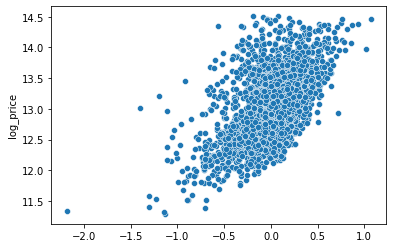

In [47]:
#Residual plot of the model with target values
sns.scatterplot(x = lm1.resid, y = train.log_price)
plt.show()

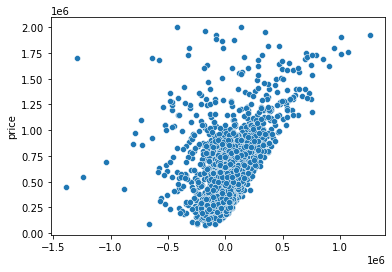

In [48]:
#Calculating residual
residual = train.price - train.pred_price

#Calculated Residual plot with target values
sns.scatterplot(x = residual, y = train.price)
plt.show()

<AxesSubplot:ylabel='Density'>

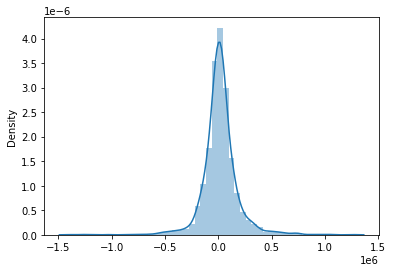

In [49]:
#Checking distribution of calculated residuals
resid = train.price - train.pred_price
sns.distplot(resid)

The distribution of the residual is normal.

In [50]:
#Getting final features
X_cols = lm1.pvalues.index.difference(['Intercept'])
X = data_house[X_cols]
Y = data_house.log_price

<BarContainer object of 18 artists>

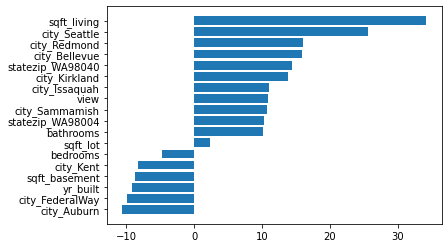

In [51]:
#Getting importance of factors
lr_fi = pd.DataFrame({'Features' : lm1.tvalues[1:].index,
                      'T_value' : lm1.tvalues[1:]
                     }).sort_values(by = 'T_value').reset_index(drop = True)
plt.barh(width = lr_fi.T_value, y = lr_fi.Features)

#### <a>Getting Train and Test dataset for Machine Learning modelling

In [52]:
train_x, test_x, train_y, test_y = train_test_split(X, Y, test_size = 0.3, random_state = 123)

#### <a>K Neighbors Model

In [53]:
#Getting parameters for best fit using GridSeachCV
pg = {'n_neighbors' : range(15,20,1)
              }

gscv_knn = GridSearchCV(estimator = KNeighborsRegressor(), 
                     param_grid = pg,
                     scoring = 'neg_mean_absolute_error',
                     cv = 14,
                     n_jobs = -1).fit(train_x, train_y)

In [54]:
#Best fit Parameters
gscv_knn.best_params_

{'n_neighbors': 17}

In [55]:
#Best Score
-1 * gscv_knn.best_score_

0.3029095045819007

In [56]:
#Using best fit parameters to fit the model
knn = gscv_knn.best_estimator_

#R2 score 
knn_r2 = metrics.r2_score(test_y, knn.predict(test_x))
print('R2 Score:', knn_r2)

#Predicting total spent on train and test dataset
train.loc[:, 'knn_pred_price'] = np.exp(knn.predict(train_x))
test.loc[:, 'knn_pred_price'] = np.exp(knn.predict(test_x))

#Getting Mean Absolute Percentage Error - MAPE
MAPE_train = np.mean(np.abs(train['price'] - train['knn_pred_price'])/train['price'])
MAPE_test = np.mean(np.abs(test['price'] - test['knn_pred_price'])/test['price'])
                    
print('Training MAPE: ',MAPE_train,' | ','Testing MAPE:' ,MAPE_test)

R2 Score: 0.40480951589945646
Training MAPE:  0.29830117395672445  |  Testing MAPE: 0.347155870640581


In [57]:
#Getting Mean Squared Error Metric - MSE
MSE_train = metrics.mean_squared_error(train.price, train.knn_pred_price)
MSE_test = metrics.mean_squared_error(test.price, test.knn_pred_price)

#Getting Root Mean Squared Error - RMSE
RMSE_train = np.sqrt(MSE_train)
knn_RMSE_test = np.sqrt(MSE_test)

print('Training MSE: ',MSE_train,' | ','Testing MSE:' ,MSE_test)
print('Training RMSE: ',RMSE_train,' | ','Testing RMSE:' ,knn_RMSE_test)

Training MSE:  46471969748.740166  |  Testing MSE: 48433627023.250015
Training RMSE:  215573.58314213774  |  Testing RMSE: 220076.41178293055


In [58]:
#Getting Mean Absolute Error Metric - MAE
MAE_train = metrics.mean_absolute_error(train.price, train.knn_pred_price)
knn_MAE_test = metrics.mean_absolute_error(test.price, test.knn_pred_price)

print('Training MAE: ', MAE_train,' | ','Testing MAE:', knn_MAE_test)

Training MAE:  146656.8860009308  |  Testing MAE: 153876.6367822628


In [59]:
#Correlation between actual and predicted values
Corr_train = stats.stats.pearsonr(train.price, train.knn_pred_price)
Corr_test = stats.stats.pearsonr(test.price, test.knn_pred_price)

print('Correlation - Train Data: ', Corr_train, '|', 'Test Data: ', Corr_test)

Correlation - Train Data:  (0.7140655345978655, 0.0) | Test Data:  (0.6449760014001575, 7.217083224404712e-160)


In [60]:
#Decile Analysis
#Creating Deciles
train.loc[:, 'knn_Deciles'] = pd.qcut(train.knn_pred_price, 10, labels = False)
test.loc[:, 'knn_Deciles'] = pd.qcut(test.knn_pred_price, 10, labels = False)

#Summarizing the data by deciles on train and test dataset
decile_train = train.groupby(['knn_Deciles'])[['price','knn_pred_price']].mean().reset_index().sort_values(by = 'knn_Deciles', ascending = False)
decile_test = test.groupby(['knn_Deciles'])[['price','knn_pred_price']].mean().reset_index().sort_values(by = 'knn_Deciles', ascending = False)

In [61]:
decile_train

,knn_Deciles,price,knn_pred_price
9,9,986783.761616,838824.713512
8,8,761689.186231,660298.511080
7,7,619985.783656,572916.804916
6,6,575626.731788,513702.308053
5,5,485273.746466,468324.969347
4,4,450859.881474,427057.405023
3,3,405455.605461,391420.748050
2,2,376862.352910,356977.140418
1,1,337345.810068,325353.224178
0,0,282573.294163,270163.352240


In [62]:
decile_test

,knn_Deciles,price,knn_pred_price
9,9,927994.766176,847184.537982
8,8,712395.325926,666514.892406
7,7,624076.178748,574326.248562
6,6,562166.139447,523325.397749
5,5,514278.598919,481799.688310
4,4,466433.867973,436273.998074
3,3,429420.403865,396316.555631
2,2,393582.675232,362924.223313
1,1,366433.482473,328641.718870
0,0,298596.398897,271907.728404


#### <a>Random Forest Model

In [63]:
#Getting parameters for best fit using GridSeachCV
pg = {  'max_depth' : range(14,20,1),
        'min_samples_split' : [2,3,4],
        'min_samples_leaf' : range(12,18,1)
              }

gscv_rf = GridSearchCV(estimator = RandomForestRegressor(random_state = 123), 
                     param_grid = pg,
                     scoring = 'neg_mean_squared_error',
                     cv = 5,
                     n_jobs = -1).fit(train_x, train_y)

In [64]:
#Best fit Parameters
gscv_rf.best_params_

{'max_depth': 16, 'min_samples_leaf': 12, 'min_samples_split': 2}

In [65]:
#Best Score
-1*gscv_rf.best_score_

0.09061343276840067

In [66]:
#Using best fit parameters to fit the model
rf = gscv_rf.best_estimator_

#R2 score 
rf_r2 = metrics.r2_score(test_y, rf.predict(test_x))
print('R2 Score:', rf_r2)

#Predicting total spent on train and test dataset
train.loc[:, 'rf_pred_price'] = np.exp(rf.predict(train_x))
test.loc[:, 'rf_pred_price'] = np.exp(rf.predict(test_x))

#Getting Mean Absolute Percentage Error - MAPE
MAPE_train = np.mean(np.abs(train['price'] - train['rf_pred_price'])/train['price'])
MAPE_test = np.mean(np.abs(test['price'] - test['rf_pred_price'])/test['price'])
                    
print('Training MAPE: ',MAPE_train,' | ','Testing MAPE:' ,MAPE_test)

R2 Score: 0.6263765681139359
Training MAPE:  0.19931335587305446  |  Testing MAPE: 0.2591656078148047


In [67]:
#Getting Mean Squared Error Metric - MSE
MSE_train = metrics.mean_squared_error(train.price, train.rf_pred_price)
MSE_test = metrics.mean_squared_error(test.price, test.rf_pred_price)

#Getting Root Mean Squared Error - RMSE
RMSE_train = np.sqrt(MSE_train)
rf_RMSE_test = np.sqrt(MSE_test)

print('Training MSE:', MSE_train,' | ','Testing MSE:', MSE_test)
print('Training RMSE:', RMSE_train,' | ','Testing RMSE:', rf_RMSE_test)

Training MSE: 24670092670.579735  |  Testing MSE: 31811796780.320877
Training RMSE: 157067.15974569521  |  Testing RMSE: 178358.61846381542


In [68]:
#Getting Mean Absolute Error Metric - MAE
MAE_train = metrics.mean_absolute_error(train.price, train.rf_pred_price)
rf_MAE_test = metrics.mean_absolute_error(test.price, test.rf_pred_price)

print('Training MAE: ',MAE_train,' | ','Testing MAE:' ,rf_MAE_test)

Training MAE:  100759.52966592726  |  Testing MAE: 117192.24121861371


In [69]:
#Correlation between actual and predicted values
Corr_train = stats.stats.pearsonr(train.price, train.rf_pred_price)
Corr_test = stats.stats.pearsonr(test.price, test.rf_pred_price)

print('Correlation - Train Data: ', Corr_train, '|', 'Test Data: ', Corr_test)

Correlation - Train Data:  (0.8575618089745127, 0.0) | Test Data:  (0.7787189868547134, 1.2730953886218262e-275)


In [70]:
#Decile Analysis
#Creating Deciles
train.loc[:, 'rf_Deciles'] = pd.qcut(train.rf_pred_price, 10, labels = False)
test.loc[:, 'rf_Deciles'] = pd.qcut(test.rf_pred_price, 10, labels = False)

#Summarizing the data by deciles on train and test dataset
decile_train = train.groupby(['rf_Deciles'])[['price','rf_pred_price']].mean().reset_index().sort_values(by = 'rf_Deciles', ascending = False)
decile_test = test.groupby(['rf_Deciles'])[['price','rf_pred_price']].mean().reset_index().sort_values(by = 'rf_Deciles', ascending = False)

In [71]:
decile_train

,rf_Deciles,price,rf_pred_price
9,9,1.096186e+06,983536.980569
8,8,7.710746e+05,726746.861254
7,7,6.477995e+05,620776.677557
6,6,5.594340e+05,535122.952448
5,5,4.981990e+05,480204.109485
4,4,4.476281e+05,439378.503462
3,3,3.982825e+05,389185.620484
2,2,3.422272e+05,338658.067214
1,1,2.864294e+05,290117.918074
0,0,2.351700e+05,239655.891487


In [72]:
decile_test

,rf_Deciles,price,rf_pred_price
9,9,1.003762e+06,983448.446854
8,8,7.362089e+05,721676.801932
7,7,6.666340e+05,620450.910770
6,6,5.572357e+05,543218.955302
5,5,5.344350e+05,491272.193238
4,4,4.652786e+05,449524.665983
3,3,4.219513e+05,401135.996046
2,2,3.538103e+05,346427.753453
1,1,3.090891e+05,294682.391313
0,0,2.467949e+05,242530.986068


#### <a>Artificial Neural Network (ANN) Model

In [73]:
train_x, test_x, train_y, test_y = train_test_split(data_house[f_cols],
                                                    data_house.price, test_size = 0.3,
                                                    random_state = 123)

In [74]:
#Input data shape
train_x.shape

(3153, 105)

In [75]:
#sc_train_x = pd.DataFrame(StandardScaler().fit_transform(train_x), columns = train_x.columns, index = train_x.index)
#sc_train_x.drop('yr_built', axis = 1, inplace = True)

In [76]:
#sc_test_x = pd.DataFrame(StandardScaler().fit_transform(test_x), columns = test_x.columns, index = test_x.index)
#sc_test_x.drop('yr_built', axis = 1, inplace = True)

In [77]:
#Initializing Neural Network
se = Sequential()
# Adding the input layer and the first hidden layer
se.add(Dense(32, activation = 'relu', kernel_initializer='uniform', input_dim = 105))
se.add(Dropout(0.2))
    
# Adding the second hidden layer
se.add(Dense(units = 64,kernel_initializer='uniform', activation = 'relu'))
se.add(Dropout(0.2))
    
# Adding the third hidden layer
se.add(Dense(units = 32,kernel_initializer='uniform', activation = 'relu'))
se.add(Dropout(0.2))
    
# Adding the output layer
    
se.add(Dense(units = 1, kernel_initializer='uniform'))

In [78]:
#Model Summary
se.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                3392      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                2112      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 3

In [79]:
#Model Configuration
se.get_config()

{'name': 'sequential',
 'layers': [{'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 105),
    'dtype': 'float32',
    'sparse': False,
    'ragged': False,
    'name': 'dense_input'}},
  {'class_name': 'Dense',
   'config': {'name': 'dense',
    'trainable': True,
    'batch_input_shape': (None, 105),
    'dtype': 'float32',
    'units': 32,
    'activation': 'relu',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'RandomUniform',
     'config': {'minval': -0.05, 'maxval': 0.05, 'seed': None}},
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'kernel_regularizer': None,
    'bias_regularizer': None,
    'activity_regularizer': None,
    'kernel_constraint': None,
    'bias_constraint': None}},
  {'class_name': 'Dropout',
   'config': {'name': 'dropout',
    'trainable': True,
    'dtype': 'float32',
    'rate': 0.2,
    'noise_shape': None,
    'seed': None}},
  {'class_name': 'Dense',
   'config': {'name': 'dense_1',
    'trainabl

In [80]:
#Compiling the model
se.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['mse'])
#Fitting the model
se.fit(train_x, train_y, epochs = 20, batch_size = 5)

Epoch 1/20
631/631 [==============================] - 4s 2ms/step - loss: 264652297306.7342 - mse: 264652297306.7342
Epoch 2/20
631/631 [==============================] - 1s 2ms/step - loss: 65329688154.7342 - mse: 65329688154.7342
Epoch 3/20
631/631 [==============================] - 1s 2ms/step - loss: 60199580484.0506 - mse: 60199580166.4810
Epoch 4/20
631/631 [==============================] - 1s 2ms/step - loss: 56321090897.0127 - mse: 56321090346.1266
Epoch 5/20
631/631 [==============================] - 1s 2ms/step - loss: 59311932918.2785 - mse: 59311932918.2785
Epoch 6/20
631/631 [==============================] - 1s 2ms/step - loss: 56134809013.4684 - mse: 56134808981.0633
Epoch 7/20
631/631 [==============================] - 1s 2ms/step - loss: 55690643916.1519 - mse: 55690643916.1519
Epoch 8/20
631/631 [==============================] - 1s 2ms/step - loss: 58320026601.3165 - mse: 58320026555.9494
Epoch 9/20
631/631 [==============================] - 1s 2ms/step - loss: 5561

In [81]:
#R2 score 
ann_r2 = metrics.r2_score(test_y, se.predict(test_x))
print('R2 Score:', ann_r2)

R2 Score: 0.4657148238986467


In [82]:
#Predicting total spent on train and test dataset
train.loc[:, 'ann_pred_price'] = se.predict(train_x)
test.loc[:, 'ann_pred_price'] = se.predict(test_x)

#Getting Mean Absolute Percentage Error - MAPE
MAPE_train = np.mean(np.abs(train['price'] - train['ann_pred_price'])/train['price'])
MAPE_test = np.mean(np.abs(test['price'] - test['ann_pred_price'])/test['price'])
                    
print('Training MAPE:',MAPE_train,' | ','Testing MAPE:' ,MAPE_test)

Training MAPE: 0.3297386966842339  |  Testing MAPE: 0.3425423576624196


In [83]:
#Getting Mean Squared Error Metric - MSE
MSE_train = metrics.mean_squared_error(train.price, train.ann_pred_price)
MSE_test = metrics.mean_squared_error(test.price, test.ann_pred_price)

#Getting Root Mean Squared Error - RMSE
RMSE_train = np.sqrt(MSE_train)
ann_RMSE_test = np.sqrt(MSE_test)

print('Training MSE: ',MSE_train,' | ','Testing MSE:' ,MSE_test)
print('Training RMSE: ',RMSE_train,' | ','Testing RMSE:' ,ann_RMSE_test)

Training MSE:  45110074964.74438  |  Testing MSE: 42607828728.84074
Training RMSE:  212391.3250694208  |  Testing RMSE: 206416.63869184756


In [84]:
#Getting Mean Absolute Error Metric - MAE
MAE_train = metrics.mean_absolute_error(train.price, train.ann_pred_price)
ann_MAE_test = metrics.mean_absolute_error(test.price, test.ann_pred_price)

print('Training MAE: ',MAE_train,' | ','Testing MAE:', ann_MAE_test)

Training MAE:  152022.24045662925  |  Testing MAE: 148140.2314500355


In [85]:
#Correlation between actual and predicted values
Corr_train = stats.stats.pearsonr(train.price, train.ann_pred_price)
Corr_test = stats.stats.pearsonr(test.price, test.ann_pred_price)

print('Correlation - Train Data: ', Corr_train, '|', 'Test Data: ', Corr_test)

Correlation - Train Data:  (0.6943969143860649, 0.0) | Test Data:  (0.6842818633150416, 2.2816461243193132e-187)


In [86]:
#Decile Analysis
#Creating Deciles
train.loc[:, 'ann_Deciles'] = pd.qcut(train.ann_pred_price, 10, labels = False)
test.loc[:, 'ann_Deciles'] = pd.qcut(test.ann_pred_price, 10, labels = False)

#Summarizing the data by deciles on train and test dataset
decile_train = train.groupby(['ann_Deciles'])[['price','ann_pred_price']].mean().reset_index().sort_values(by = 'ann_Deciles', ascending = False)
decile_test = test.groupby(['ann_Deciles'])[['price','ann_pred_price']].mean().reset_index().sort_values(by = 'ann_Deciles', ascending = False)

In [87]:
decile_train

,ann_Deciles,price,ann_pred_price
9,9,986015.804358,923768.003362
8,8,744135.260990,722080.174008
7,7,620333.081282,630090.220437
6,6,559185.807657,559904.415675
5,5,486436.159562,504225.194940
4,4,449679.601850,458765.612935
3,3,424619.518141,415599.254861
2,2,376871.526102,369327.866766
1,1,345990.625498,316558.039980
0,0,289173.998656,243064.034167


In [88]:
decile_test

,ann_Deciles,price,ann_pred_price
9,9,977483.369118,941275.258272
8,8,710354.017284,736002.102778
7,7,623669.839300,637526.593981
6,6,570934.280952,566363.402778
5,5,480181.726499,512033.535417
4,4,466080.064893,462045.626620
3,3,417556.113997,415998.109028
2,2,402576.458879,371451.775463
1,1,366501.882649,312980.064583
0,0,279812.640790,243987.419347


#### <a>Evaluating the different metrics for each model

In [89]:
#Getting accuracy and log loss for each model
model_data = pd.DataFrame({'Regressor' : ['LinearRegressor', 'RandomForestRegressor', 'KNeighborsRegressor', 'ArtificialNeuralNetwork'],
                        'R2 Score' : [lm1.rsquared, rf_r2, knn_r2, ann_r2],
                        'RMSE' : [lr_RMSE_test, rf_RMSE_test, knn_RMSE_test, ann_RMSE_test],
                        'MAE' : [lr_MAE_test, rf_MAE_test, knn_MAE_test, ann_MAE_test]})

In [90]:
model_data

,Regressor,R2 Score,RMSE,MAE
0,LinearRegressor,0.708644,170528.143035,107448.054972
1,RandomForestRegressor,0.626377,178358.618464,117192.241219
2,KNeighborsRegressor,0.404810,220076.411783,153876.636782
3,ArtificialNeuralNetwork,0.465715,206416.638692,148140.231450


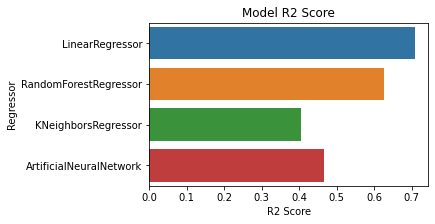

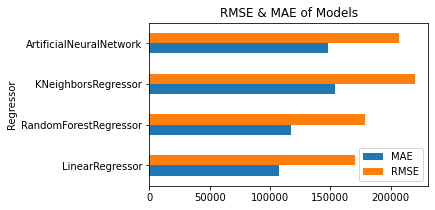

In [91]:
#Visualizing the accuracy and log loss of each model
plt.figure(figsize = (5,3))
sns.barplot(data = model_data, x = model_data['R2 Score'], y = model_data.Regressor)
plt.title('Model R2 Score')
plt.show()

model_data.plot(x = 'Regressor', y = ['MAE', 'RMSE'], kind = 'barh', figsize = (5,3))
plt.title('RMSE & MAE of Models')
plt.show()

Linear Regression Model has the highest R2 Score and the lowest MAE and RMSE Score. So, we will choose Linear Regression Model for Predicting House prices.